# Initializer Comparison with ReLU Activation

In [1]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import OrderedDict

In [2]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, din):
        dx = np.dot(din, self.W.T)
        self.dW = np.dot(self.x.T, din)
        self.db = np.sum(din, axis=0)
        return dx

In [3]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, din):
        dx = din * self.out * (1.0 - self.out)
        return dx
    
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, din):
        din[self.mask] = 0
        dx = din
        return dx

## Five layers and Activation Values

In [90]:
def activation_value_histogram(layers, num_epoch, forward_plt=False, backward_plt=False, describe=False):
    x = np.random.randn(1000, 100) # 1000 x 100
    y = np.ones((1000, 100))

    num_layers = len(layers)
    activations = OrderedDict()
    backward_activations = OrderedDict()
    
    forward = {}
    backward = {}

    for epoch in range(num_epoch):
        forward[epoch] = []
        backward[epoch] = []
        
        if forward_plt:        
            print("Epoch:", epoch)
        # Forward
        for i in range(num_layers):
            if i != 0:
                x = activations[i-1]
            activations[i] = layers[i].forward(x)

        # Backward    
        for i in reversed(range(num_layers)):
            if i != num_layers - 1:
                y = backward_activations[i+1]
            backward_activations[i] = layers[i].backward(y)

        # Parameter Update
        for i in range(num_layers):
            if i % 2 == 0:
                layers[i].W = layers[i].W - 0.01 * layers[i].dW
                layers[i].b = layers[i].b - 0.01 * layers[i].db

        # Histograms of Forward Activation Values
        if forward_plt:
            print("Forward Activations")
            f, axarr = plt.subplots(1, num_layers, figsize=(25, 5))
            f.subplots_adjust(wspace=0.5)
        for i, a in activations.items():
            values = list(a.flatten())
            forward[epoch].append((np.mean(values), np.std(values)))
            if forward_plt:
                std = "{:5.4f}".format(np.std(values))
                axarr[i].hist(values, 20)
                if i % 2 == 0:
                    axarr[i].set_title(str(i+1) + "-Layer ($\sigma=$" + std + ")")
                else:
                    axarr[i].set_title("ReLU Layer ($\sigma=$" + std + ")")
        if forward_plt:
            plt.show()

        # Histograms of Backward Activation Values
        if backward_plt:        
            print("Backward Activations")
            f, axarr = plt.subplots(1, num_layers, figsize=(25, 5))
            f.subplots_adjust(wspace=0.5)
        for i, b in backward_activations.items():
            values = list(b.flatten())
            backward[epoch].append((np.mean(values), np.std(values)))
            if backward_plt:                    
                std = "{:5.4f}".format(np.std(values))
                axarr[i].hist(values, 20)
                if i % 2 == 0:
                    axarr[i].set_title(str(i+1) + "-Layer ($\sigma=$" + std + ")")
                else:
                    axarr[i].set_title("ReLU Layer ($\sigma=$" + std + ")") 
        if backward_plt:
            plt.show()
            
    if describe:
        for epoch in range(num_epochs):
            forward_mean_str = ""
            forward_str = "" 
            backward_mean_str = ""
            backward_str = ""
            print("[Forward Epoch {:d}]".format(epoch))
            for layer in range(num_layers):
                print("Layer {:d}, mean {:f}, std {:f}".format(layer, forward[epoch][layer][0], forward[epoch][layer][1]))
            print("[Backward Epoch {:d}]".format(epoch))        
            for layer in range(num_layers):
                print("Layer {:d}, mean {:f}, std {:f}".format(layer, backward[epoch][layer][0], backward[epoch][layer][1]))        
            print()        
            
    return forward, backward

## 1. Weight and Bias Variation with ReLU Activation

In [91]:
markers = {
    "zero": "h",
    "normal1": "_",     
    "normal2": "|", 
    "trunc_normal": "v",
    "lecun_normal": "x",
    "lecun_uniform": "s",
    "xavier_normal": "+", 
    "xavier_uniform": "d",     
    "he_normal": "*",         
    "he_uniform": "o"
}

forward_dic = OrderedDict()
backward_dic = OrderedDict()

### 1) Only Zero Values
- Weight Distribution: $W = 0$
- Bias Distribution: $B = 0$

In [92]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 Affine층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

for i in range(num_layers):
    if i % 2 == 0:
        w = np.zeros((node_num, node_num))
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()

forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['zero'] = forward
backward_dic['zero'] = backward

### 2) Standard Normal Distribution
- Weight Distribution: $W \sim N(0, 1)$
- Bias Distribution: $B = 0$

In [93]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 은닉층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

for i in range(num_layers):
    if i % 2 == 0:
        w = np.random.randn(node_num, node_num)
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()

forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['normal1'] = forward
backward_dic['normal1'] = backward

### 3) Standard Normal Distribution where Standard Deviation is 0.01 
- Weight Distribution: $W \sim N(0, 0.0001)$
- Bias Distribution: $B = 0$

In [94]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 은닉층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

std = 0.01
for i in range(num_layers):
    if i % 2 == 0:
        w = np.random.randn(node_num, node_num) * std
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()
        
forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['normal2'] = forward
backward_dic['normal2'] = backward

### 4) Truncated Standard Normal Distribution where Standard Deviation is 0.01 
- Weight Distribution: $W \sim N(0, 0.0001)$
- Bias Distribution: $B = 0$

In [9]:
def get_truncated_normal(shape, mean=0, sd=1, low=0, upp=10):
    x = truncnorm(a=(low - mean) / sd, b=(upp - mean) / sd, loc=mean, scale=sd)
    num_elements = 1
    for dim in shape:
        num_elements *= dim
    x = x.rvs(num_elements)
    x = x.reshape(shape)
    return x

In [95]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 은닉층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

from scipy.stats import truncnorm

std = 0.01

for i in range(num_layers):
    if i % 2 == 0:
        w = get_truncated_normal(shape=(node_num, node_num), mean=0.0, sd=std, low=-std, upp=std)
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()
        
forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['trunc_normal'] = forward
backward_dic['trunc_normal'] = backward

### 5) Lecun - (Truncated) Normal

In [96]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 은닉층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

from scipy.stats import truncnorm

for i in range(num_layers):
    if i % 2 == 0:
        sd = math.sqrt(1.0 / node_num)
        w = get_truncated_normal(shape=(node_num, node_num), mean=0.0, sd=std, low=-std, upp=std)
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()
        
forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['lecun_normal'] = forward
backward_dic['lecun_normal'] = backward

### 6) Lecun - Uniform

In [97]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 은닉층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

from scipy.stats import truncnorm

for i in range(num_layers):
    if i % 2 == 0:
        sd = math.sqrt(1.0 / node_num)
        w = np.random.uniform(low=-sd, high=sd, size=(node_num, node_num))
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()
        
forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['lecun_uniform'] = forward
backward_dic['lecun_uniform'] = backward

### 7) Xavier - (Tuncated) Normal

In [98]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 은닉층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

from scipy.stats import truncnorm

for i in range(num_layers):
    if i % 2 == 0:
        sd = math.sqrt(1.0 / (node_num + node_num))
        w = get_truncated_normal(shape=(node_num, node_num), mean=0.0, sd=std, low=-std, upp=std)
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()
        
forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['xavier_normal'] = forward
backward_dic['xavier_normal'] = backward

### 8) Xavier - Uniform

In [99]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 은닉층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

from scipy.stats import truncnorm

for i in range(num_layers):
    if i % 2 == 0:
        sd = math.sqrt(1.0 / (node_num + node_num))
        w = np.random.uniform(low=-sd, high=sd, size=(node_num, node_num))
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()
        
forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['xavier_uniform'] = forward
backward_dic['xavier_uniform'] = backward

### 9) He - (Truncated) Normal

In [100]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 은닉층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

from scipy.stats import truncnorm

for i in range(num_layers):
    if i % 2 == 0:
        sd = math.sqrt(2.0 / (node_num + node_num))
        w = get_truncated_normal(shape=(node_num, node_num), mean=0.0, sd=std, low=-std, upp=std)
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()
        
forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['he_normal'] = forward
backward_dic['he_normal'] = backward

### 10) He - Uniform 

In [101]:
node_num = 100 #각 은닉층의 노드 수
num_layers = 6 # 3개의 은닉층 + 3개의 활성화층
num_epochs = 5

layers = OrderedDict()

from scipy.stats import truncnorm

for i in range(num_layers):
    if i % 2 == 0:
        sd = math.sqrt(2.0 / (node_num + node_num))
        w = np.random.uniform(low=-sd, high=sd, size=(node_num, node_num))
        b = np.zeros(node_num)
        layers[i] = Affine(w, b)
    else:    
        layers[i] = Relu()
        
forward, backward = activation_value_histogram(layers, num_epochs, forward_plt=False, backward_plt=False, describe=False)
forward_dic['he_uniform'] = forward
backward_dic['he_uniform'] = backward

### Mean of Forward Activation Values per Epoch (0, 1, 2, 3, 4)

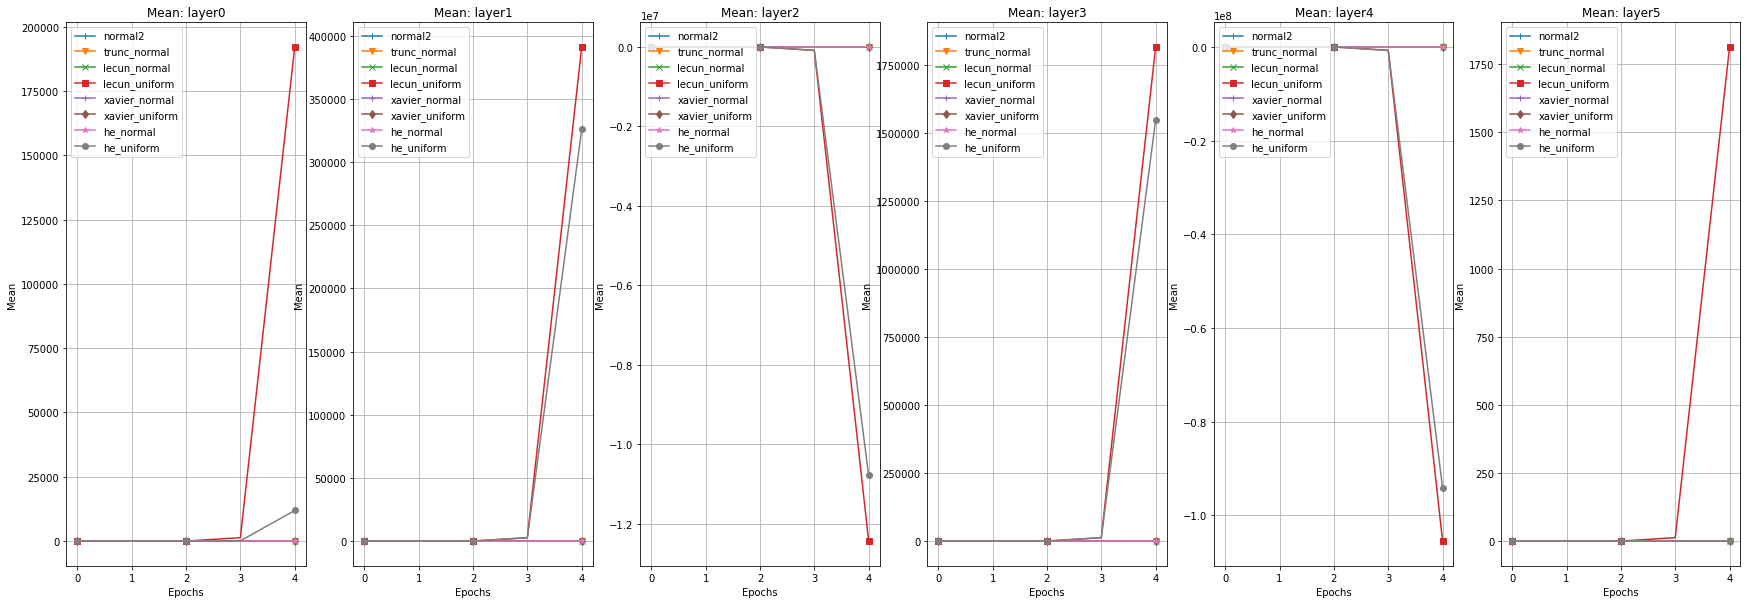

In [102]:
%matplotlib inline
epoch_list = np.arange(num_epochs)

f, axarr = plt.subplots(1, 6, figsize=(30,10))

for layer in range(6):
    for key, forward in forward_dic.items():
        if key not in ("zero", "normal1"):
            mean_per_layer = []
            for epoch in range(num_epochs):
                mean_per_layer.append(forward[epoch][layer][0])
            axarr[layer].plot(epoch_list, mean_per_layer, marker=markers[key], markevery=2, label=key)
    axarr[layer].set_ylabel('Mean')
    axarr[layer].set_xlabel('Epochs')
    axarr[layer].grid(True)
    axarr[layer].set_title('Mean: layer' + str(layer))
    axarr[layer].legend(loc='upper left')

f.subplots_adjust(hspace=0.7)
    
plt.show()    

### Standard Deviation of Forward Activation Values per Epoch (0, 1, 2, 3, 4)

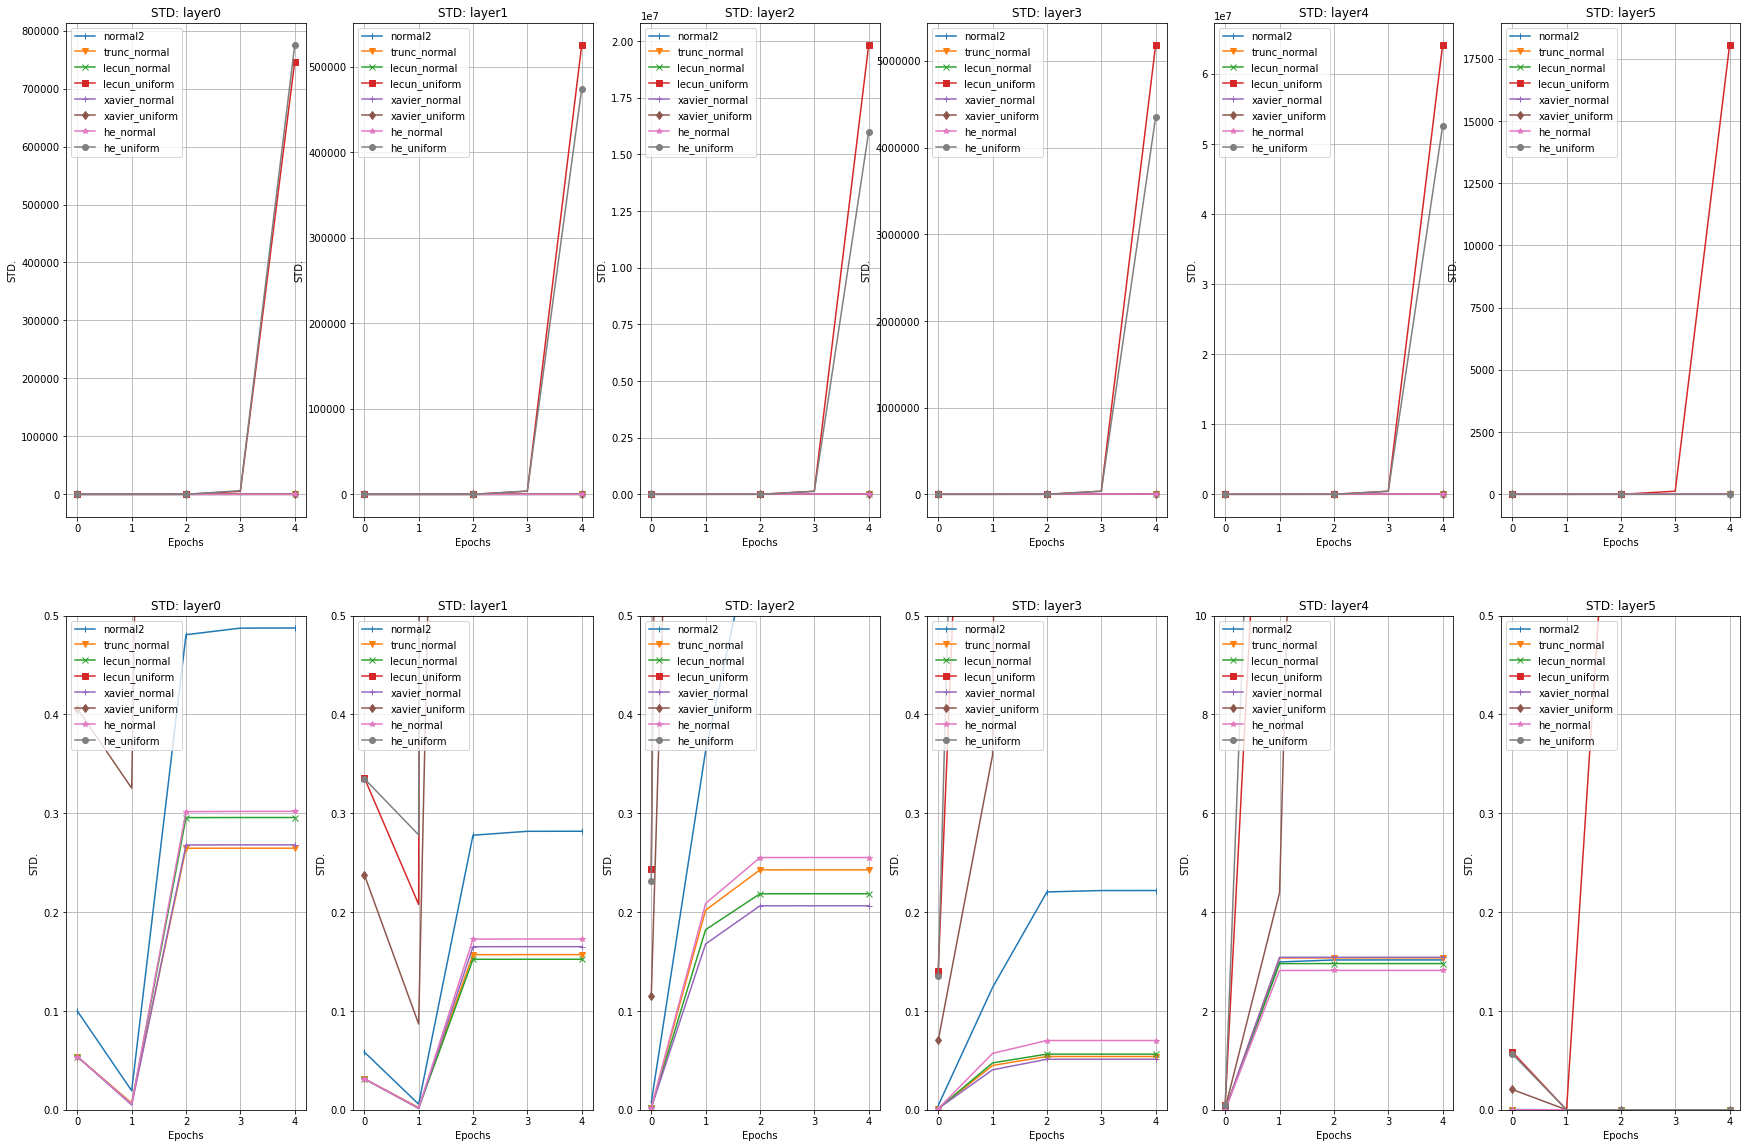

In [103]:
epoch_list = np.arange(num_epochs)

f, axarr = plt.subplots(2, 6, figsize=(30, 20))

for layer in range(6):
    for key, forward in forward_dic.items():
        if key not in ("zero", "normal1"):
            std_per_layer = []
            for epoch in range(num_epochs):
                std_per_layer.append(forward[epoch][layer][1])
            axarr[0, layer].plot(epoch_list, std_per_layer, marker=markers[key], markevery=2, label=key)
    axarr[0, layer].set_ylabel('STD.')
    axarr[0, layer].set_xlabel('Epochs')
    axarr[0, layer].grid(True)
    axarr[0, layer].set_title('STD: layer' + str(layer))
    axarr[0, layer].legend(loc='upper left')
    
    for key, forward in forward_dic.items():
        if key not in ("zero", "normal1"):
            std_per_layer = []
            for epoch in range(num_epochs):
                std_per_layer.append(forward[epoch][layer][1])
            axarr[1, layer].plot(epoch_list, std_per_layer, marker=markers[key], markevery=2, label=key)
    axarr[1, layer].set_ylabel('STD.')
    axarr[1, layer].set_xlabel('Epochs')
    axarr[1, layer].grid(True)
    if layer == 4:
        axarr[1, layer].set_ylim(0.0, 10.0)
    else:
        axarr[1, layer].set_ylim(0.0, 0.5)
    axarr[1, layer].set_title('STD: layer' + str(layer))
    axarr[1, layer].legend(loc='upper left')

plt.show()    